# Challenge
Challenge: model comparison
You now know two kinds of regression and two kinds of classifier. So let's use that to compare models!

Comparing models is something data scientists do all the time. There's very rarely just one model that would be possible to run for a given situation, so learning to choose the best one is very important.

Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.

### pipeline

0. data loading
1. data cleaning
2. EDA
    - missing data
    - outlier
    - normal distribution establishmwent
    - normalization
    - multi variable relationship
3. mahcine learning
    - model formulation
    - data split
    - model fit
4. evaluation

### 0. Load the houseprices data from Thinkful's database.

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
import sklearn

import math
import seaborn as sns

import scipy.stats as stats
import scipy

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [77]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [78]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()




### 2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.


In [79]:
# get rid of the columns with nan. (since we don't need that many features)

df_drop = df.copy()
for col in df_drop.columns:
    if df_drop[col].isna().any():
#         print(col)
        df_drop = df_drop.drop(columns=col)    

# in this regression task, let's use continous type features
for (col,col_type) in zip(df_drop.columns,df_drop.dtypes):
    if col_type == 'object':
        df_drop = df_drop.drop(columns=col)

In [80]:
# handeling outlier (winsor)
def outlier_handeler_myfun(df_drop, col_target = 'saleprice', percentile_num_print= True, fig_show = True):

    import scipy.stats.mstats


    df_tmp = df_drop.copy()
    
    
    if (fig_show):
    # saleprice: our target
        plt.boxplot(df_tmp[col_target])
        plt.title("{} (whis=1.5)".format(col_target))
        plt.show()

        plt.figure(figsize=(15, 20))
        for col,index in zip(df_tmp.columns.unique(), range(len(df_tmp.columns.unique()))):

            plt.subplot(len(df_tmp.columns) // 3 +1,3,index+1)
            plt.boxplot(df_tmp[col])
            plt.title("{} (whis=1.5)".format(col))
        plt.show()



    # winsor

    # count outliers under 1.5 threshold, represent in portion for later use in winsorization
    threshold = 1.5
    record_num = len(df_tmp)

    lower_list = []
    upper_list = []
    for col,index in zip(df_tmp.columns.unique(), range(len(df_tmp.columns.unique()))):
        if col not in ['id']:
            q75, q25 = np.percentile(df_tmp[col], [75 ,25])
            iqr = q75 - q25
            min_val = q25 - (iqr*threshold)
            max_val = q75 + (iqr*threshold)
    #         store the upper bound and lower bound
            lower_list.append(len(np.where((df_tmp[col] < min_val))[0]) / record_num)
            upper_list.append(len(np.where((df_tmp[col] > max_val))[0]) / record_num)
            if (percentile_num_print):
                print("{:25s} : ".format(col)
                + "percentile of lower outliers is: {:2f},\t   ".format(len(np.where((df_tmp[col] < min_val))[0]) / record_num)\
                + "percentile of upper outliers is: {:2f}. ".format(len(np.where((df_tmp[col] > max_val))[0]) / record_num) ) 

    df_winsor = df_tmp.copy()
    # df_winsor = df.copy()
    # winsorized_list = df_tmp.columns
    winsorized_list=[]
    for col in df_tmp.columns:
        if col not in ['id']:
    #         print(col)
            winsorized_list.append( col)


    for col,index in zip(winsorized_list, range(len(winsorized_list))):
    #     if col not in ['Country', 'Year', 'Status']:
        df_winsor[col] = scipy.stats.mstats.winsorize(df_winsor[col], (lower_list[index], upper_list[index]))
    #         winsorized_list.append('winsorized_'+ col)



    df_tmp = df_winsor.copy()

    # visualize outliers again
    # df_tmp = df_drop.copy()
    # col_num = len(df_tmp.columns) // 3

    # saleprice: our target
    if (fig_show):
        plt.boxplot(df_tmp[col_target])
        plt.title("{} (whis=1.5)".format(col_target))
        plt.show()

        plt.figure(figsize=(15, 20))
        for col,index in zip(df_tmp.columns.unique(), range(len(df_tmp.columns.unique()))):

            plt.subplot(len(df_tmp.columns) // 3 +1,3,index+1)
            plt.boxplot(df_tmp[col])
            plt.title("{} (whis=1.5)".format(col))
        plt.show()
        
    return df_tmp

        
# df_tmp = outlier_handeler_myfun(df_drop, col_target = 'saleprice', percentile_num_print= True, fig_show = True)
df_tmp = outlier_handeler_myfun(df_drop, col_target = 'saleprice', percentile_num_print= False, fig_show = False)

##### when the correlation between feature and target varialbe is too low (< 0.1), those features might not be helpful to explain the target variable in our linear regression model, so we can drop them.
also, we would like to avoid colinearity between features, otherwise might cause unstability, so we can drop features in the high correlation coefficient pairs.

# algorithm:

- 1. check features pair with collinearity higher than certain threshold (i.e. > 0.5)
- 2. in the feature pair, get rid of the one has lower correalation coefficient(cc) on target

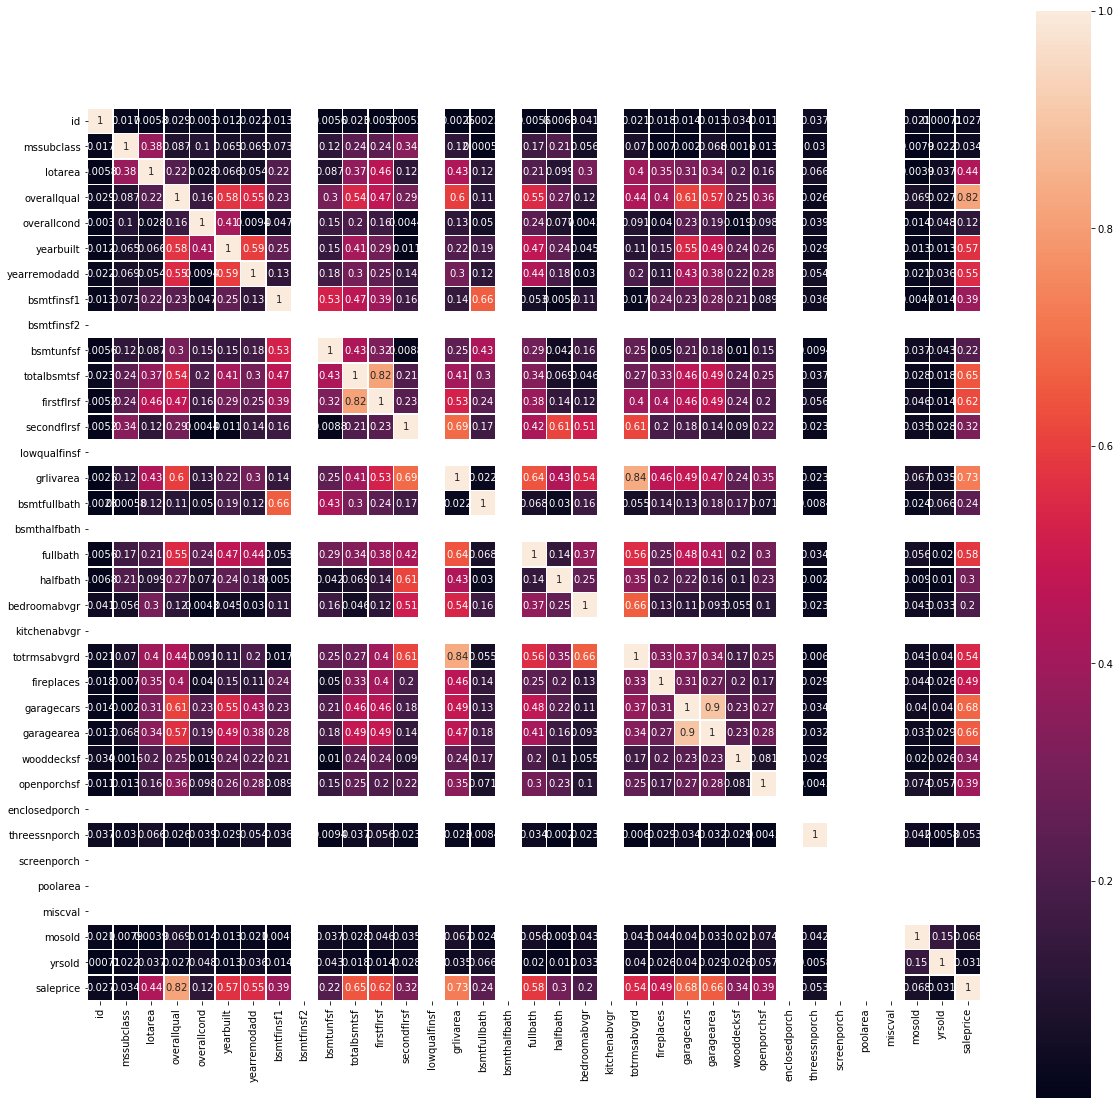

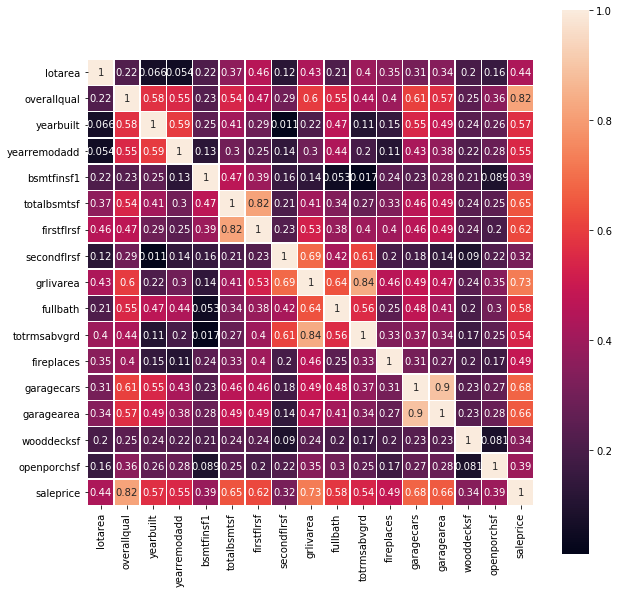

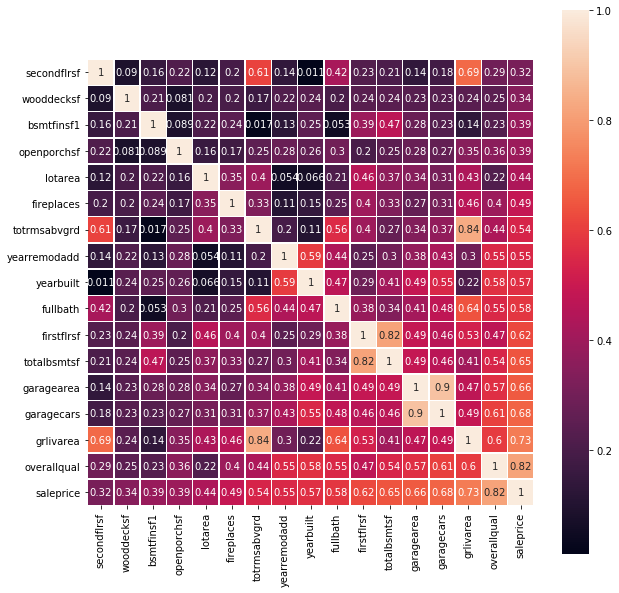

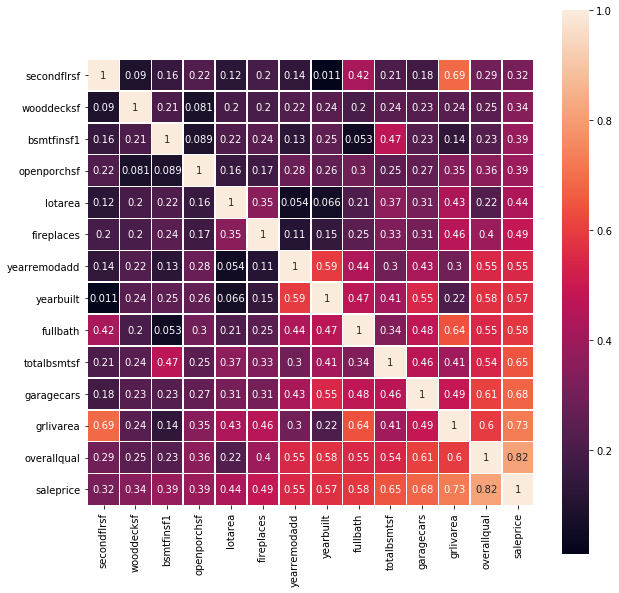

In [81]:
# check correlation using heatmap

df_tmp = df_tmp.copy()
corr_matrix = np.abs(df_tmp.corr())
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, square=True, annot=True, linewidths=.5)
plt.show()

df_drop_2 = df_tmp.copy()

corr_matrix = np.abs(df_drop_2.corr())
col_index_list = []
for (index, val) in enumerate(corr_matrix.iloc[:,-1]):
#     print (index, val)
    if val > 0.3 :
        col_index_list.append(index)
col_index_list

df_drop_2 = df_drop_2.iloc[:, col_index_list].copy()

corr_matrix = np.abs(df_drop_2.corr())
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, square=True, annot=True, linewidths=.5)
plt.show()


# sort columns based on the correalation coefficient between feature and target,
# so that the algorithm will be easier to apply
df_drop_3 = df_drop_2.copy()
corr_matrix = np.abs(df_drop_3.corr())
s_sort = corr_matrix.iloc[:,-1].sort_values()
df_drop_3 = df_drop_3.loc[:,s_sort.index]

corr_matrix = np.abs(df_drop_3.corr())

corr_matrix = np.abs(df_drop_3.corr())
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, square=True, annot=True, linewidths=.5)
plt.show()


# drop the columns when collinearity between features is higher than threshold,
# since we've already sorted the columns, so the lower cc between feature and target will drop out first

df_drop_4 = df_drop_3.copy()
corr_thres = 0.7
count = 15


corr_matrix = np.abs(df_drop_4.corr())
corr_matrix.iloc[:-1,:-1][np.abs(corr_matrix)==1] = -10
while((corr_matrix.iloc[:-1,:-1]>corr_thres).any(axis=None)   and count >0):
    col_current = 0
    while col_current < len(corr_matrix):        
        if (corr_matrix.iloc[col_current,:-1]>corr_thres).any():
#             print("current col: ", col_current)
            df_drop_4.drop(columns=df_drop_4.columns[col_current], axis=1, inplace=True)
            corr_matrix = np.abs(df_drop_4.corr())
            corr_matrix.iloc[:-1,:-1][np.abs(corr_matrix)==1] = -10  
            col_current = len(corr_matrix)
        else:        
            col_current +=1
#             print("current col: ", col_current)
                      
    count -=1
#     print("count is: ", count)
#     print(df_drop_4.columns)

# check the cc again
corr_matrix = np.abs(df_drop_4.corr())
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, square=True, annot=True, linewidths=.5)
plt.show()


### we will pick the remained variables as the features to feed in the linear regression model


# 3. model formulation, data split, model fit

In [82]:
# pick the features
# X = df[['openporchsf', 'wooddecksf', 'fireplaces', 'overallqual']]
X = df_drop_4
X = X.drop(columns=['saleprice'])
Y = df_drop_4['saleprice']
# Y = np.log1p(Y)


# split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))



The number of observations in training set is 1168
The number of observations in test set is 292


-----OLS Training set statistics-----
constant: -1259848.1240835218, coefficient: [-5.07022076e-01  1.77215396e+01  1.62447918e+01  2.93371409e+01
  1.73711705e+00  7.05049151e+03  3.72432510e+02  2.41056639e+02
 -4.38004337e+03  1.83901154e+01  9.56960797e+03  4.35838630e+01
  1.58922933e+04]
R-squared of the model in training set is: 0.8637085018018276
-----OLS Test set statistics-----
R-squared of the model in test set is: 0.8811838362620443
Mean absolute error of the prediction is: 17035.92936524451
Mean squared error of the prediction is: 530562136.65084964
Root mean squared error of the prediction is: 23033.934458768646
Mean absolute percentage error of the prediction is: 11.272564171063015


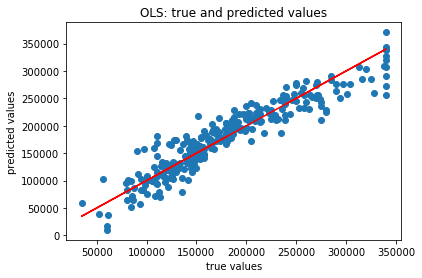

In [83]:
from sklearn.linear_model import LinearRegression
# using OLS 

def lrm_myfun(X_train, X_test, y_train, y_test): 
    lrm = LinearRegression()

    lrm.fit(X_train, y_train)


    # We are making predictions here
    y_preds_train = lrm.predict(X_train)
    y_preds_test = lrm.predict(X_test)
    
    


    print("-----OLS Training set statistics-----")
    print("constant: {}, coefficient: {}".format(lrm.intercept_, lrm.coef_))
    print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
    print("-----OLS Test set statistics-----")
    print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
    print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
    print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

    # make a scatter plot to compare predicated and actual

    plt.scatter(y_test, y_preds_test)
    plt.plot(y_test, y_test, color="red")
    plt.xlabel("true values")
    plt.ylabel("predicted values")
    plt.title("OLS: true and predicted values")
    plt.show()

    
    
lrm_myfun(X_train, X_test, y_train, y_test)

# part II
### 2. EDA

In [95]:
# for knn, the most important EDA is normalization
# note that there is an option for axis, 'axis used to normalize the data along. 
# If 1, independently normalize each sample, otherwise (if 0) normalize each feature.'

# also, KNN doesn't handel categorical variables very well (the distance just do not make sense here). 
# So we need to get rid of them as well.

In [96]:
# without outlier
X = df_drop_4
X = X.drop(columns=['saleprice'])
Y = df_drop_4['saleprice']


# normalization
X_normalized = X.copy()
for col in X_normalized.columns:
    X_normalized[col]= sklearn.preprocessing.normalize(np.array(X_normalized[col]).reshape(1,-1), axis = 1).reshape(-1,1)
    
y_normalized = Y.copy()
y_normalized= sklearn.preprocessing.normalize(np.array(y_normalized).reshape(1,-1), axis=1).reshape(-1)


# split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [97]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
from sklearn import neighbors


def knn_get_k(x_train, y_train):
    r_min = 0
    for k in range(1,200,1):
        knn = neighbors.KNeighborsRegressor(n_neighbors=k, weights='distance')
        # X = pd.DataFrame(music.loudness)
#         X = pd.DataFrame(music[['loudness','duration']] )
#         Y = music.bpm
        knn.fit(x_train, y_train)

        score = cross_val_score(knn, x_train, y_train, cv=5)
        if score.mean() > r_min:
            r_min = score.mean()
            std_associated = score.std()*2
            k_associated = k
            
    print("k= {}".format(k_associated))
    print("Distance weighted Accuracy: %0.4f (+/- %0.4f)" % (r_min, std_associated))
    
knn_get_k(X_train, np.array(y_train))

k= 7
Distance weighted Accuracy: 0.7896 (+/- 0.0399)


-----KNN Training set statistics-----
R-squared of the model in training set is: 0.9999837183823964
-----KNN Test set statistics-----
R-squared of the model in test set is: 0.7836106251604705
Mean absolute error of the prediction is: 0.003178785195997444
Mean squared error of the prediction is: 1.8405048923904093e-05
Root mean squared error of the prediction is: 0.004290110595766046
Mean absolute percentage error of the prediction is: 14.503719903341786


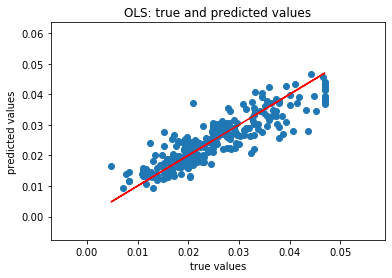

In [98]:
def knn_myfun(X_train, X_test, y_train, y_test, k=7): 
    knn = neighbors.KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)


    # We are making predictions here
    y_preds_train = knn.predict(X_train)
    y_preds_test = knn.predict(X_test)
    
    


    print("-----KNN Training set statistics-----")
#     print("constant: {}, coefficient: {}".format(lrm.intercept_, lrm.coef_))
    print("R-squared of the model in training set is: {}".format(knn.score(X_train, y_train)))
    print("-----KNN Test set statistics-----")
    print("R-squared of the model in test set is: {}".format(knn.score(X_test, y_test)))
    print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
    print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

    # make a scatter plot to compare predicated and actual

    plt.scatter(y_test, y_preds_test)
    plt.plot(y_test, y_test, color="red")
    plt.xlabel("true values")
    plt.ylabel("predicted values")
    plt.title("OLS: true and predicted values")
    plt.show()

    
    
knn_myfun(X_train, X_test, y_train, y_test)

# sumary
- Nodel comparison between OLS and KNN. In this house sale price regression problem, OLS has better performance than KNN. Per MAPE on test data, we ahve OLS:11% vs. KNN:14% (the lower the better), R^2 value OLS: 78% vs. KNN: 74% (the higher the better)
- We also observed a big drop in R^2 score on training data and test data when using KNN, plus the R^2 score on test data is extremely high, which indicate overfitting issue.
- Unlike linear regression estimator like Lasso, Ridge, KNN does not have embedded feature engineering tools, i.e. no parameter in KNN tells us how much impact certain feature is. 
- Data normalization is essential for KNN, because the estimator is sensitive to distance in different scale. So, data normalization should be included in the KNN regression pipeline. (a trial in appendix show that without data normalization, the performance deteriorate)
- Outlier also has significant impact on both OLS and KNN. While, it would be very interesting how to handel outliers, i.e. using winsorization drop the record (if not lossing too much data)
- Disscusion: 


# discussion
should we compare the evaluation reslut using the raw dataset (i.e. without transformation) or should we use the one that after data cleaning (i.e. get rid of outliers and transform to make more normal distributed). If we are using the transformed version, how can we gurantee we properly handle outliers with the unseen dataset.

### appendix: some trial

### trial: more features (without outlier handeling)

In [99]:
# trial 1
# we make sure the evaluation is on the same dataset, so the target data should be the raw data, instead of winsored data
X_original = df[X.columns].copy()
Y_original = df['saleprice']

X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_original, Y_original, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [100]:
# trial: more features
    
# without outlier
X = df_drop.copy()
X = X.drop(columns=['saleprice'])
Y = df_drop['saleprice']


# normalization
X_normalized = X.copy()
for col in X_normalized.columns:
    X_normalized[col]= sklearn.preprocessing.normalize(np.array(X_normalized[col]).reshape(1,-1), axis = 1).reshape(-1,1)
    
y_normalized = Y.copy()
y_normalized= sklearn.preprocessing.normalize(np.array(y_normalized).reshape(1,-1), axis=1).reshape(-1)


# split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))  


print(knn_get_k(X_train, np.array(y_train)))

The number of observations in training set is 1168
The number of observations in test set is 292
k= 12
Distance weighted Accuracy: 0.6516 (+/- 0.1212)
None


-----KNN Training set statistics-----
R-squared of the model in training set is: 1.0
-----KNN Test set statistics-----
R-squared of the model in test set is: 0.6732237096809426
Mean absolute error of the prediction is: 0.0036117380085953017
Mean squared error of the prediction is: 3.8490913178104584e-05
Root mean squared error of the prediction is: 0.006204104542809106
Mean absolute percentage error of the prediction is: 15.653366044857616


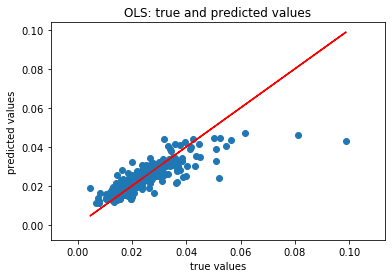

In [101]:
knn_myfun(X_train, X_test, y_train, y_test, k=12)

### trial without normalization

In [102]:
# without outlier
X = df_drop_4
X = X.drop(columns=['saleprice'])
Y = df_drop_4['saleprice']


# normalization
X_normalized = X.copy()
# for col in X_normalized.columns:
#     X_normalized[col]= sklearn.preprocessing.normalize(np.array(X_normalized[col]).reshape(1,-1), axis = 1).reshape(-1,1)
    
y_normalized = Y.copy()
# y_normalized= sklearn.preprocessing.normalize(np.array(y_normalized).reshape(1,-1), axis=1).reshape(-1)


# split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [103]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
from sklearn import neighbors


def knn_get_k(x_train, y_train):
    r_min = 0
    for k in range(1,200,1):
        knn = neighbors.KNeighborsRegressor(n_neighbors=k, weights='distance')
        # X = pd.DataFrame(music.loudness)
#         X = pd.DataFrame(music[['loudness','duration']] )
#         Y = music.bpm
        knn.fit(x_train, y_train)

        score = cross_val_score(knn, x_train, y_train, cv=5)
        if score.mean() > r_min:
            r_min = score.mean()
            std_associated = score.std()*2
            k_associated = k
            
    print("k= {}".format(k_associated))
    print("Distance weighted Accuracy: %0.4f (+/- %0.4f)" % (r_min, std_associated))
    
knn_get_k(X_train, np.array(y_train))

k= 8
Distance weighted Accuracy: 0.6797 (+/- 0.0971)


-----KNN Training set statistics-----
R-squared of the model in training set is: 0.9999837183823964
-----KNN Test set statistics-----
R-squared of the model in test set is: 0.7439503604082632
Mean absolute error of the prediction is: 24841.881648871564
Mean squared error of the prediction is: 1143365006.8864717
Root mean squared error of the prediction is: 33813.68076513516
Mean absolute percentage error of the prediction is: 16.14126961632261


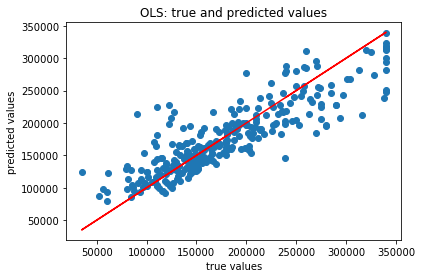

In [104]:
 knn_myfun(X_train, X_test, y_train, y_test, k=8)